In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.hub
from functools import partial


from timm.models.layers import DropPath, to_2tuple, trunc_normal_
from timm.models.registry import register_model
from timm.models.vision_transformer import _cfg, Mlp, Block
import numpy as np
import torch
import torch_xla
import torch_xla.core.xla_model as xm

import pandas as pd
import numpy as np
import csv
import torch
import ctypes
import gc
import os

import dataset
import torch
import warnings

import pandas as pd
import numpy as np
import torch.nn as nn

from sklearn import metrics
from transformers import AdamW
from transformers import get_linear_schedule_with_warmup

import torch_xla.core.xla_model as xm
import torch_xla.distributed.parallel_loader as pl
import torch_xla.distributed.xla_multiprocessing as xmp
torch.manual_seed(42)
os.environ['PJRT_DEVICE'] = 'TPU' 
# os.environ['PT_XLA_DEBUG_LEVEL'] = '2'
# os.environ['XLA_DYNAMO_DEBU'] = '1'
# os.environ['PT_XLA_DEBUG'] = '1'
# os.environ['XLA_SYNC_WAIT'] = '1'
warnings.filterwarnings("ignore")
libc = ctypes.CDLL("libc.so.6")
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.hub
from functools import partial


from timm.models.layers import DropPath, to_2tuple, trunc_normal_
from timm.models.registry import register_model
from timm.models.vision_transformer import _cfg, Mlp, Block
import numpy as np
import torch

import pandas as pd
import numpy as np
import csv
import torch
import ctypes
import gc
import os

import torch
import warnings

import pandas as pd
import numpy as np
import torch.nn as nn

from sklearn import metrics
from transformers import AdamW
from transformers import get_linear_schedule_with_warmup

torch.manual_seed(42)
warnings.filterwarnings("ignore")
libc = ctypes.CDLL("libc.so.6")

In [2]:
import numpy as np

import torch

def get_2d_sincos_pos_embed(embed_dim, grid_size, cls_token=False):
    """
    grid_size: int of the grid height and width
    return:
    pos_embed: [grid_size*grid_size, embed_dim] or [1+grid_size*grid_size, embed_dim] (w/ or w/o cls_token)
    """
    grid_h = np.arange(grid_size, dtype=np.float32)
    grid_w = np.arange(grid_size, dtype=np.float32)
    grid = np.meshgrid(grid_w, grid_h)  # here w goes first
    grid = np.stack(grid, axis=0)

    grid = grid.reshape([2, 1, grid_size, grid_size])
    pos_embed = get_2d_sincos_pos_embed_from_grid(embed_dim, grid)
    if cls_token:
        pos_embed = np.concatenate([np.zeros([1, embed_dim]), pos_embed], axis=0)
    return pos_embed


def get_2d_sincos_pos_embed_from_grid(embed_dim, grid):
    assert embed_dim % 2 == 0

    # use half of dimensions to encode grid_h
    emb_h = get_1d_sincos_pos_embed_from_grid(embed_dim // 2, grid[0])  # (H*W, D/2)
    emb_w = get_1d_sincos_pos_embed_from_grid(embed_dim // 2, grid[1])  # (H*W, D/2)

    emb = np.concatenate([emb_h, emb_w], axis=1) # (H*W, D)
    return emb


def get_1d_sincos_pos_embed_from_grid(embed_dim, pos):
    """
    embed_dim: output dimension for each position
    pos: a list of positions to be encoded: size (M,)
    out: (M, D)
    """
    assert embed_dim % 2 == 0
    omega = np.arange(embed_dim // 2, dtype='float32')
    omega /= embed_dim / 2.
    omega = 1. / 10000**omega  # (D/2,)

    pos = pos.reshape(-1)  # (M,)
    out = np.einsum('m,d->md', pos, omega)  # (M, D/2), outer product

    emb_sin = np.sin(out) # (M, D/2)
    emb_cos = np.cos(out) # (M, D/2)

    emb = np.concatenate([emb_sin, emb_cos], axis=1)  # (M, D)
    return emb

import math
from collections import OrderedDict
from functools import partial
from typing import Any, Callable, Dict, List, NamedTuple, Optional

import torch
import torch.nn as nn
import torch.nn.functional as F

from torchvision.ops.misc import Conv2dNormActivation, MLP
from torchvision.transforms._presets import ImageClassification, InterpolationMode
from torchvision.utils import _log_api_usage_once
from torchvision.models._api import register_model, Weights, WeightsEnum
from torchvision.models._meta import _IMAGENET_CATEGORIES
from torchvision.models._utils import _ovewrite_named_param, handle_legacy_interface


class CrissCrossMultiheadSelfAttention(nn.Module):
    def __init__(self, k_factor, num_heads, in_channels):
        super(CrissCrossMultiheadSelfAttention, self).__init__()
        self.k_factor = k_factor
        self.num_heads = num_heads
        self.in_channels = in_channels


        self.qkv_linear = nn.ModuleList()
        for _ in range(in_channels):
            self.qkv_linear.append(nn.Linear(k_factor, k_factor * 3))
        self.fc_out = nn.Linear(k_factor, k_factor)

    def forward(self, x):
        '''
        The following input shape can be achieved by modifying the convolutional layers
        in the ViT preprocessing to be depth-wise with in_channels = K*in_channels and
        groups = in_channels where K is the scale factor of how many convolutional
        filters you want for each image channel
        V,K,Q input shape: batch_size, length, hidden_dim*channels
        '''
        N = x.shape[0]

        #channels shape: [[batch_size, length, hidden_dim], ...] list length=in_channels
        in_channels = x.chunk(self.in_channels, dim=2)

        queries = []
        keys = []
        values = []
        for channel, qkv in zip(in_channels, self.qkv_linear):
            q, k, v = qkv(channel).chunk(3, dim=-1)
            queries.append(q)
            keys.append(k)
            values.append(v)

        #q, k before: [[batch_size, length, hidden_dim], ...] list length=in_channels
        queries = torch.stack(queries, -1).unsqueeze(-1)
        keys = torch.stack(keys, -1).unsqueeze(-2)
        values = torch.stack(values, -1)
        #q shape after: (batch_size, length, hidden_dim, in_channels, 1)
        #k shape after: (batch_size, length, hidden_dim, 1, in_channels)

        #scores shape: (batch_size, length, hidden_dim, in_channels, in_channels)
        scores = torch.matmul(queries, keys) / (self.k_factor ** 0.5)
        attention = F.softmax(scores, -1)

        #context shape: (batch_size, length, hidden_dim, in_channels)
        context = torch.einsum('ijklm,ijkl->ijkm', attention, values)

        #context shape: (batch_size, length, in_channels, hidden_dim)
        context = context.transpose(-2, -1)

        out = self.fc_out(context)

        #out shape: (batch_size, length, in_channels * hidden_dim)
        out = out.flatten(start_dim=2)

        return out

class CrissCrossMultiheadCrossAttention(nn.Module):
    def __init__(self, k_factor, num_heads, in_channels):
        super(CrissCrossMultiheadCrossAttention, self).__init__()
        self.k_factor = k_factor
        self.num_heads = num_heads
        self.in_channels = in_channels


        self.q_linear = nn.ModuleList()
        self.kv_linear = nn.ModuleList()
        for _ in range(in_channels):
            self.q_linear.append(nn.Linear(k_factor, k_factor))
            self.kv_linear.append(nn.Linear(k_factor, k_factor * 2))
        self.fc_out = nn.Linear(k_factor, k_factor)

    def forward(self, x, context):
        '''
        The following input shape can be achieved by modifying the convolutional layers
        in the ViT preprocessing to be depth-wise with in_channels = K*in_channels and
        groups = in_channels where K is the scale factor of how many convolutional
        filters you want for each image channel
        V,K,Q input shape: batch_size, length, hidden_dim*channels
        '''
        N = x.shape[0]

        #channels shape: [[batch_size, length, hidden_dim], ...] list length=in_channels
        in_channels = x.chunk(self.in_channels, dim=2)

        context_in_channels = context.chunk(self.in_channels, dim=2)

        queries = []
        keys = []
        values = []
        for channel, cont_channel, q_lin, kv_lin in zip(in_channels, context_in_channels, self.q_linear, self.kv_linear):
            q = q_lin(channel)
            k, v = kv_lin(cont_channel).chunk(2, dim=-1)
            queries.append(q)
            keys.append(k)
            values.append(v)

        #q, k before: [[batch_size, length, hidden_dim], ...] list length=in_channels
        queries = torch.stack(queries, -1).unsqueeze(-1)
        keys = torch.stack(keys, -1).unsqueeze(-2)
        values = torch.stack(values, -1)
        #q shape after: (batch_size, length, hidden_dim, in_channels, 1)
        #k shape after: (batch_size, length, hidden_dim, 1, in_channels)

        #scores shape: (batch_size, length, hidden_dim, in_channels, in_channels)
        scores = torch.matmul(queries, keys) / (self.k_factor ** 0.5)
        attention = F.softmax(scores, -1)

        #context shape: (batch_size, length, hidden_dim, in_channels)
        context = torch.einsum('ijklm,ijkl->ijkm', attention, values)

        #context shape: (batch_size, length, in_channels, hidden_dim)
        context = context.transpose(-2, -1)

        out = self.fc_out(context)

        #out shape: (batch_size, length, in_channels * hidden_dim)
        out = out.flatten(start_dim=2)

        return out


class ConvStemConfig(NamedTuple):
    out_channels: int
    kernel_size: int
    stride: int
    norm_layer: Callable[..., nn.Module] = nn.BatchNorm2d
    activation_layer: Callable[..., nn.Module] = nn.ReLU


class MLPBlock(MLP):
    """Transformer MLP block."""

    _version = 2

    def __init__(self, in_dim: int, mlp_dim: int, dropout: float):
        super().__init__(in_dim, [mlp_dim, in_dim], activation_layer=nn.GELU, inplace=None, dropout=dropout)

        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                if m.bias is not None:
                    nn.init.normal_(m.bias, std=1e-6)

    def _load_from_state_dict(
        self,
        state_dict,
        prefix,
        local_metadata,
        strict,
        missing_keys,
        unexpected_keys,
        error_msgs,
    ):
        version = local_metadata.get("version", None)

        if version is None or version < 2:
            # Replacing legacy MLPBlock with MLP. See https://github.com/pytorch/vision/pull/6053
            for i in range(2):
                for type in ["weight", "bias"]:
                    old_key = f"{prefix}linear_{i+1}.{type}"
                    new_key = f"{prefix}{3*i}.{type}"
                    if old_key in state_dict:
                        state_dict[new_key] = state_dict.pop(old_key)

        super()._load_from_state_dict(
            state_dict,
            prefix,
            local_metadata,
            strict,
            missing_keys,
            unexpected_keys,
            error_msgs,
        )


class EncoderBlock(nn.Module):
    """Transformer encoder block."""

    def __init__(
        self,
        num_heads: int,
        hidden_dim: int,
        in_channels: int,
        k_factor: int,
        mlp_dim: int,
        dropout: float,
        attention_dropout: float,
        norm_layer: Callable[..., torch.nn.Module] = partial(nn.LayerNorm, eps=1e-6),
    ):
        super().__init__()
        self.num_heads = num_heads

        # Attention block
        self.ln_1 = norm_layer(hidden_dim)
        self.self_attention = CrissCrossMultiheadSelfAttention(k_factor, num_heads, in_channels)
        self.dropout = nn.Dropout(dropout)

        # MLP block
        self.ln_2 = norm_layer(hidden_dim)
        self.mlp = MLPBlock(hidden_dim, mlp_dim, dropout)

    def forward(self, input: torch.Tensor):
        torch._assert(input.dim() == 3, f"Expected (batch_size, seq_length, hidden_dim) got {input.shape}")
        x = self.ln_1(input)
        x = self.self_attention(x)
        x = self.dropout(x)
        x = x + input

        y = self.ln_2(x)
        y = self.mlp(y)
        return x + y


class Encoder(nn.Module):
    """Transformer Model Encoder for sequence to sequence translation."""

    def __init__(
        self,
        seq_length: int,
        num_layers: int,
        num_channels: int,
        k_factor: int,
        num_heads: int,
        hidden_dim: int,
        mlp_dim: int,
        dropout: float,
        attention_dropout: float,
        norm_layer: Callable[..., torch.nn.Module] = partial(nn.LayerNorm, eps=1e-6),
    ):
        super().__init__()
        self.enc_pos_embedding = nn.Parameter(torch.empty(1, seq_length + 1, hidden_dim).normal_(std=0.02))  # from BERT
        self.dropout = nn.Dropout(dropout)
        layers: OrderedDict[str, nn.Module] = OrderedDict()
        for i in range(num_layers):
            layers[f"encoder_layer_{i}"] = EncoderBlock(
                num_heads,
                hidden_dim,
                num_channels,
                k_factor,
                mlp_dim,
                dropout,
                attention_dropout,
                norm_layer,
            )
        self.layers = nn.Sequential(layers)
        self.ln = norm_layer(hidden_dim)
        self.cls_token = nn.Parameter(torch.zeros(1, 1, hidden_dim))


    def random_masking(self, x, mask_ratio):
        """
        Perform per-sample random masking by per-sample shuffling.
        Per-sample shuffling is done by argsort random noise.
        x: [N, L, D], sequence
        """
        N, L, D = x.shape  # batch, length, dim
        len_keep = int(L * (1 - mask_ratio))

        noise = torch.rand(N, L, device=x.device)  # noise in [0, 1]

        # sort noise for each sample
        ids_shuffle = torch.argsort(noise, dim=1)  # ascend: small is keep, large is remove
        ids_restore = torch.argsort(ids_shuffle, dim=1)

        # keep the first subset
        ids_keep = ids_shuffle[:, :len_keep]
        x_masked = torch.gather(x, dim=1, index=ids_keep.unsqueeze(-1).repeat(1, 1, D))

        # generate the binary mask: 0 is keep, 1 is remove
        mask = torch.ones([N, L], device=x.device)
        mask[:, :len_keep] = 0
        # unshuffle to get the binary mask
        mask = torch.gather(mask, dim=1, index=ids_restore)

        return x_masked, mask, ids_restore

    def forward(self, input: torch.Tensor, mask_ratio=0.5):
        torch._assert(input.dim() == 3, f"Expected (batch_size, seq_length, hidden_dim) got {input.shape}")
        input = input + self.enc_pos_embedding[:, 1:, :]
        input, mask, ids_restore = self.random_masking(input, mask_ratio)
        cls_token = self.cls_token + self.enc_pos_embedding[:, :1, :]
        cls_tokens = cls_token.expand(input.shape[0], -1, -1)
        input = torch.cat((cls_tokens, input), dim=1)
        return self.ln(self.layers(self.dropout(input))), mask, ids_restore


class DecoderBlock(nn.Module):
    """Transformer decoder block."""

    def __init__(
        self,
        num_heads: int,
        hidden_dim: int,
        in_channels: int,
        k_factor: int,
        mlp_dim: int,
        dropout: float,
        attention_dropout: float,
        norm_layer: Callable[..., torch.nn.Module] = partial(nn.LayerNorm, eps=1e-6),
    ):
        super().__init__()
        self.num_heads = num_heads

        # Attention block
        self.ln_1 = norm_layer(hidden_dim)
        self.self_attention = CrissCrossMultiheadSelfAttention(k_factor, num_heads, in_channels)
        self.ln_2 = norm_layer(hidden_dim)
        self.cross_attention = CrissCrossMultiheadCrossAttention(k_factor, num_heads, in_channels)
        self.dropout = nn.Dropout(dropout)

        # MLP block
        self.ln_3 = norm_layer(hidden_dim)
        self.mlp = MLPBlock(hidden_dim, mlp_dim, dropout)

    def forward(self, input: torch.Tensor, context: torch.Tensor):
        torch._assert(input.dim() == 3, f"Expected (batch_size, seq_length, hidden_dim) got {input.shape}")
        input = self.ln_1(input)
        x = self.self_attention(input)
        input = input + self.dropout(x)
        x = self.ln_2(input)
        x = self.cross_attention(x, context)
        input = input + self.dropout(x)

        y = self.ln_3(x)
        y = self.mlp(y)
        return x + y


class Decoder(nn.Module):
    """Transformer Model Decoder for sequence to sequence translation."""

    def __init__(
        self,
        seq_length: int,
        num_layers: int,
        num_channels: int,
        k_factor: int,
        num_heads: int,
        hidden_dim: int,
        mlp_dim: int,
        dropout: float,
        attention_dropout: float,
        norm_layer: Callable[..., torch.nn.Module] = partial(nn.LayerNorm, eps=1e-6),
    ):
        super().__init__()
        self.dec_pos_embedding = nn.Parameter(torch.empty(1, seq_length + 1, hidden_dim).normal_(std=0.02))  # from BERT
        layers: OrderedDict[str, nn.Module] = OrderedDict()
        for i in range(num_layers):
            layers[f"encoder_layer_{i}"] = DecoderBlock(
                num_heads,
                hidden_dim,
                num_channels,
                k_factor,
                mlp_dim,
                dropout,
                attention_dropout,
                norm_layer,
            )
        self.layers = nn.Sequential(layers)
        self.ln = norm_layer(hidden_dim)
        self.mask_token = nn.Parameter(torch.zeros(1, 1, hidden_dim))
        self.cls_token = nn.Parameter(torch.zeros(1, 1, hidden_dim))

    def forward(self, x: torch.Tensor, context: torch.Tensor, ids_restore: torch.Tensor):
        torch._assert(x.dim() == 3, f"Expected (batch_size, seq_length, hidden_dim) got {x.shape}")
        cls_token = self.cls_token + self.dec_pos_embedding[:, :1, :]
        cls_tokens = cls_token.expand(x.shape[0], -1, -1)
        x = torch.cat((cls_tokens, x), dim=1)

        mask_tokens = self.mask_token.repeat(context.shape[0], ids_restore.shape[1] + 1 - context.shape[1], 1)
        context_ = torch.cat([context[:, 1:, :], mask_tokens], dim=1)  # no cls token
        context_ = torch.gather(context_, dim=1, index=ids_restore.unsqueeze(-1).repeat(1, 1, context.shape[2]))  # unshuffle
        context = torch.cat([context[:, :1, :], context_], dim=1)  # append cls token
        context = context + self.dec_pos_embedding

        for l in self.layers:
            x = l(x, context)
        return self.ln(x)



class DepthwiseCrossViTMAE(nn.Module):
    def __init__(
        self,
        image_size: int,
        patch_size: int,
        in_channels: int,
        k_factor: int,
        num_layers: int,
        num_heads: int,
        hidden_dim: int,
        mlp_dim: int,
        dropout: float = 0.0,
        attention_dropout: float = 0.0,
        num_classes: int = 1,
        norm_layer: Callable[..., torch.nn.Module] = partial(nn.LayerNorm, eps=1e-6),
        mask_ratio: float = 0.5,
    ):
        super().__init__()
        _log_api_usage_once(self)
        torch._assert(image_size % patch_size == 0, "Input shape indivisible by patch size!")
        self.image_size = image_size
        self.patch_size = patch_size
        self.in_channels = in_channels
        self.k_factor = k_factor
        self.hidden_dim = hidden_dim
        self.mlp_dim = mlp_dim
        self.attention_dropout = attention_dropout
        self.dropout = dropout
        self.num_classes = num_classes
        self.norm_layer = norm_layer
        self.mask_ratio = mask_ratio

        self.conv_proj = nn.Conv2d(
            in_channels=in_channels, groups=in_channels, out_channels=in_channels*k_factor, kernel_size=patch_size, stride=patch_size
        )

        seq_length = (image_size // patch_size) ** 2

        # Add a class token
        self.class_token = nn.Parameter(torch.zeros(1, 1, hidden_dim))

        self.encoder = Encoder(
            seq_length,
            num_layers,
            in_channels,
            k_factor,
            num_heads,
            hidden_dim,
            mlp_dim,
            dropout,
            attention_dropout,
            norm_layer,
        )

        self.decoder = Decoder(
            seq_length,
            num_layers,
            in_channels,
            k_factor,
            num_heads,
            hidden_dim,
            mlp_dim,
            dropout,
            attention_dropout,
            norm_layer,
        )

        self.seq_length = seq_length

        if isinstance(self.conv_proj, nn.Conv2d):
            # Init the patchify stem
            fan_in = self.conv_proj.in_channels * self.conv_proj.kernel_size[0] * self.conv_proj.kernel_size[1]
            nn.init.trunc_normal_(self.conv_proj.weight, std=math.sqrt(1 / fan_in))
            if self.conv_proj.bias is not None:
                nn.init.zeros_(self.conv_proj.bias)
        elif self.conv_proj.conv_last is not None and isinstance(self.conv_proj.conv_last, nn.Conv2d):
            # Init the last 1x1 conv of the conv stem
            nn.init.normal_(
                self.conv_proj.conv_last.weight, mean=0.0, std=math.sqrt(2.0 / self.conv_proj.conv_last.out_channels)
            )
            if self.conv_proj.conv_last.bias is not None:
                nn.init.zeros_(self.conv_proj.conv_last.bias)


    def _process_input(self, x: torch.Tensor) -> torch.Tensor:
        n, c, h, w = x.shape
        p = self.patch_size
        torch._assert(h == self.image_size, f"Wrong image height! Expected {self.image_size} but got {h}!")
        torch._assert(w == self.image_size, f"Wrong image width! Expected {self.image_size} but got {w}!")
        n_h = h // p
        n_w = w // p

        # (n, c, h, w) -> (n, hidden_dim, n_h, n_w)
        x = self.conv_proj(x)
        # (n, in_channels * k_factor, n_h, n_w) -> (n, in_channels * k_factor, (n_h * n_w))
        x = x.reshape(n, self.in_channels * self.k_factor, n_h * n_w)

        # (n, in_channels * k_factor, (n_h * n_w)) -> (n, (n_h * n_w), in_channels * k_factor)
        # The self attention layer expects inputs in the format (N, L, D)
        # where L is the source sequence length, N is the batch size, D is the
        # embedding dimension
        x = x.permute(0, 2, 1)

        return x

    def forward_loss(self, target, pred, mask):
        """
        imgs: [N, C, H, W]
        pred: [N, L, p*p*C]
        mask: [N, L], 0 is keep, 1 is remove,
        """
        mean = target.mean(dim=-1, keepdim=True)
        var = target.var(dim=-1, keepdim=True)
        target = (target - mean) / (var + 1.e-6)**.5

        loss = (pred - target) ** 2
        loss = loss.mean(dim=-1)  # [N, L], mean loss per patch


        loss = (loss * mask).sum() / mask.sum()  # mean loss on removed patches
        return loss

    def forward(self, imgs: torch.Tensor):
        # Reshape and permute the input tensor
        imgs = self._process_input(imgs)
        n = imgs.shape[0]

        enc_output, mask, ids_restore = self.encoder(imgs, self.mask_ratio)
        x = self.decoder(imgs, enc_output, ids_restore)

        # Remove the class token
        x = x[:, 1:, :]

        loss = self.forward_loss(imgs, x, mask)
        return loss, x, mask


def _vision_transformer(
    patch_size: int,
    in_channels: int,
    k_factor: int,
    num_layers: int,
    num_heads: int,
    hidden_dim: int,
    mlp_dim: int,
    weights: Optional[WeightsEnum],
    progress: bool,
    **kwargs: Any,
) -> DepthwiseCrossViTMAE:
    if weights is not None:
        _ovewrite_named_param(kwargs, "num_classes", len(weights.meta["categories"]))
        assert weights.meta["min_size"][0] == weights.meta["min_size"][1]
        _ovewrite_named_param(kwargs, "image_size", weights.meta["min_size"][0])
    image_size = kwargs.pop("image_size", 125)

    model = DepthwiseCrossViTMAE(
        image_size=image_size,
        in_channels=in_channels,
        k_factor=k_factor,
        patch_size=patch_size,
        num_layers=num_layers,
        num_heads=num_heads,
        hidden_dim=hidden_dim,
        mlp_dim=mlp_dim,
        **kwargs,
    )

    if weights:
        model.load_state_dict(weights.get_state_dict(progress=progress, check_hash=True))

    return model

model = _vision_transformer(
                            patch_size=5,
                            in_channels=8,
                            k_factor=16,
                            num_layers=12,
                            num_heads=4,
                            hidden_dim=128,
                            mlp_dim=64,
                            weights=None,
                            progress=False,
                            )

model.load_state_dict(torch.load('/home/shashank/notebooks/Trained models/Reconstruction/Criss-Cross-attention/best_model.pth', map_location=torch.device('cpu')))

<All keys matched successfully>

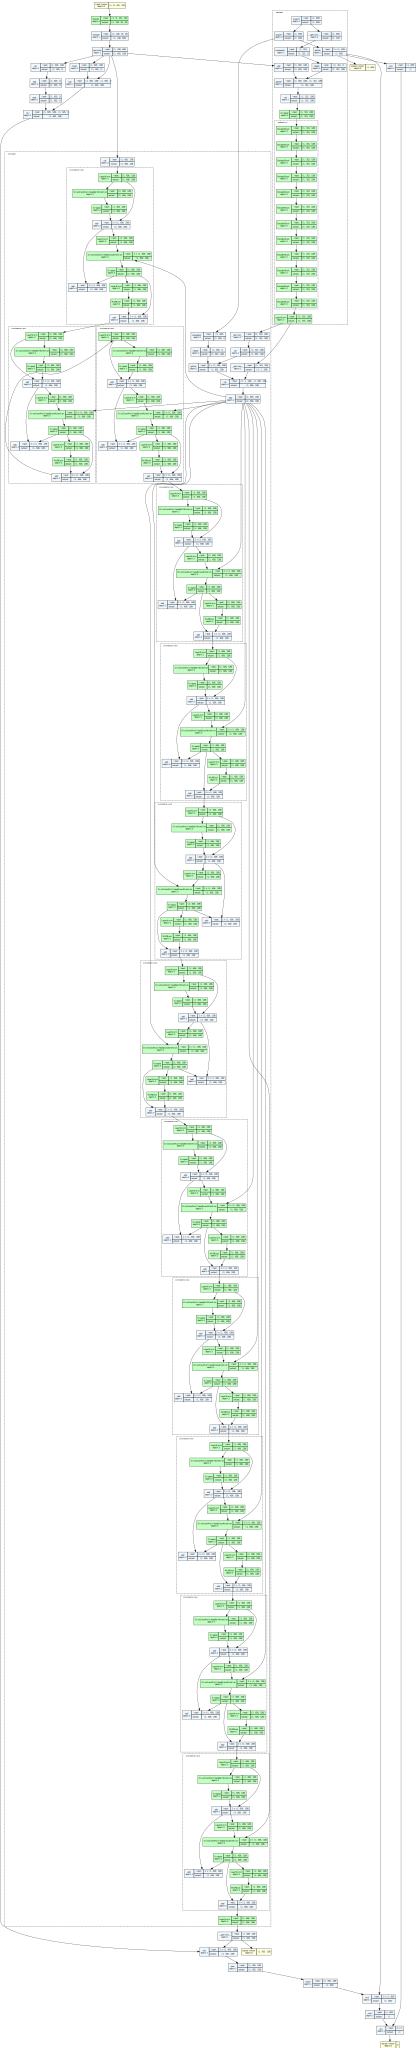

In [3]:
import torchvision
from torchview import draw_graph
from torchviz import make_dot

model_graph = draw_graph(model, input_size=(1,8,125,125), expand_nested=True)
model_graph.visual_graph

In [4]:
# notebooks/Trained models/Reconstruction/Criss-Cross-attention/best_model.pth

In [5]:
import os
import numpy as np
from PIL import Image
from concurrent.futures import ThreadPoolExecutor
from tqdm import tqdm
import gc

def load_image(path):
    with Image.open(path) as f:
        img_array = np.array(f).reshape((125, 125, 8)).astype('float32')
    return img_array

def load_images_from_directory(directory, label):
    paths = [os.path.join(directory, file) for file in os.listdir(directory)][:50000]
    with ThreadPoolExecutor() as executor:
        images = list(tqdm(executor.map(load_image, paths), total=len(paths)))
    labels = [label] * len(images)
    return images, labels

# Load images from both directories
X_one, y_one = load_images_from_directory('/home/shashank/dataset/dataset/one/', 0)
X_two, y_two = load_images_from_directory('/home/shashank/dataset/dataset/two/', 1)

# Combine datasets
X = X_one + X_two
Y = y_one + y_two

100%|██████████| 50000/50000 [05:02<00:00, 165.19it/s]


In [6]:
from sklearn.utils import shuffle
X, Y = shuffle(X, Y, random_state = 42)
X_train = X[:int(len(X)*0.8)]
X_test = X[int(len(X)*0.8):len(X)]
Y_train = Y[:int(len(X)*0.8)]
Y_test = Y[int(len(X)*0.8):len(X)]
Y_train = np.array(Y_train).astype('float32')
Y_test = np.array(Y_test).astype('float32')
X_train = np.array(X_train).astype('float32')
X_test = np.array(X_test).astype('float32')

print(X_train.shape)
print(Y_train.shape)

(80000, 125, 125, 8)
(80000,)


In [7]:
import os
import torch
import pandas as pd
# from skimage import io, transform
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
import os
import torch
import pandas as pd
from skimage import io, transform
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils

class Custom_Dataset(Dataset):
    def __init__(self, x, y, transform = None):
        self.x = x
        self.y = y
        self.transform = transform
        
    def __len__(self):
        return self.x.shape[0]
    
    def __getitem__(self,idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        img_1 = torch.from_numpy(self.x[idx]).moveaxis(2, 0)/255.0
        # img = self.x[idx]
        label = torch.tensor(self.y[idx])

        if self.transform:
            img_1 = self.transform(img_1)
            
        sample = {'img' : img_1, 'label' : label}
        
        return sample

# transform = transforms.Compose([
#     transforms.Resize((224, 224)),  # Resize to 224x224
# ])

t_dataset = Custom_Dataset(X_train, Y_train)
y_dataset = Custom_Dataset(X_test, Y_test)
t_dataloader = DataLoader(t_dataset, batch_size = 8)
# t_dataloader = DataLoader(t_dataset, batch_size = 8)
sample = t_dataset.__getitem__(1)
print((sample['img']).max())
print(sample['label'])


tensor(1.)
tensor(1.)


In [8]:
class FromPretrainedDecoder(nn.Module):
    def __init__(self, pretrained_model, hidden_dim, num_classes):
        super().__init__()
        self.pretrained_model = pretrained_model
        
        for param in self.pretrained_model.parameters():
            param.requires_grad = False
            
        self.linear1 = nn.Linear(hidden_dim, 32)
        self.linear = nn.Linear(32, num_classes)
        self.linear2 = nn.Linear(hidden_dim, num_classes)
        self.batchnorm = nn.BatchNorm1d(hidden_dim)
        self.batchnorm1 = nn.BatchNorm1d(32)
        self.sigmoid = nn.Sigmoid()
        self.relu = nn.ReLU()

    def forward(self, x):
        imgs = self.pretrained_model._process_input(x)
        encoded_tensor, masks, ids= self.pretrained_model.encoder(imgs, 0)
        op = encoded_tensor.mean(axis = 1)
        x = op
        # x = op.mean(axis = 1)
        x = self.batchnorm(x)
        x = self.relu(x)
        x = self.linear2(x)
        
        return x

pretrained_model = FromPretrainedDecoder(pretrained_model=model,
                                         hidden_dim=128,
                                         num_classes=1)

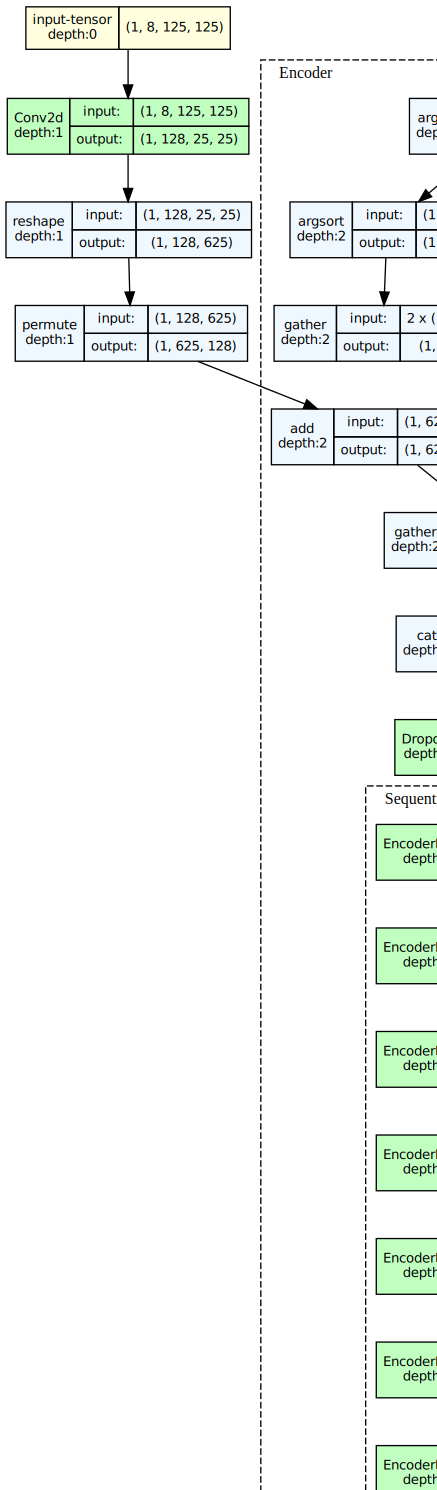

In [9]:
import torchvision
from torchview import draw_graph
from torchviz import make_dot

model_graph = draw_graph(pretrained_model, input_size=(1,8,125,125), expand_nested=True)
model_graph.visual_graph

In [10]:
# model.train()
for batch in t_dataloader:
    img = batch['img']
    lab = batch['label']
    break
pred = pretrained_model(img)
torch.sigmoid(pred)

tensor([[0.5114],
        [0.5114],
        [0.5114],
        [0.5114],
        [0.5114],
        [0.5114],
        [0.5114],
        [0.5114]], grad_fn=<SigmoidBackward0>)

In [11]:
criterion = nn.BCEWithLogitsLoss(reduction = "mean")
loss = criterion(pred.squeeze(), lab)
loss

tensor(0.6763, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)

In [12]:
def reduce_fn(vals):
    # take average
    # xm.print(len(vals))
    return sum(vals) / len(vals)

In [13]:
def lr_lambda(epoch):
    warmup_epochs = 3
    decay_rate = 0.8
    if epoch < warmup_epochs:
        # Linear increase during warmup
        return float(epoch + 1) / warmup_epochs
    else:
        # Exponential decay after warmup
        return decay_rate ** (epoch - warmup_epochs + 1)

In [14]:
from tqdm import tqdm
from torchmetrics import Accuracy, AUROC
def train_one_epoch(epoch, epochs, model, train_dataloader, valid_dataloader, scheduler, device, optimizer):
    train_loss = []
    valid_loss = []
    accuracy = Accuracy(task = 'binary').to(device)
    auroc = AUROC(task='binary').to(device)
    criterion = nn.BCEWithLogitsLoss(reduction = "mean")
    # criterion = nn.BCELoss()
    
    train_accuracies = []
    val_accuracies = []
    train_aurocs = []
    val_aurocs = []
    
    model.train()
    # scheduler.step()

    for step, batch in tqdm(enumerate(train_dataloader), desc=f'Epoch {epoch+1}/{epochs} (Train)', unit='batch'):
        image = batch['img'].to(device)
        label = batch['label'].to(device)
        
        optimizer.zero_grad()
        
        outputs = model(image)
        outputs = outputs.squeeze()
        
        loss = criterion(outputs, label)

        loss.backward()
        xm.optimizer_step(optimizer)
        loss_reduced = xm.mesh_reduce('loss_reduce',loss.item(),reduce_fn) 
        # outputs_reduced = xm.mesh_reduce('outputs_reduce',outputs.item(),reduce_fn) 
        
        train_loss.append(loss_reduced)
        train_acc = accuracy(outputs, label)
        train_auroc = auroc(outputs, label)
        
        train_acc_red = xm.mesh_reduce('loss_reduce',train_acc.item(),reduce_fn) 
        train_auc_red = xm.mesh_reduce('loss_reduce',train_auroc.item(),reduce_fn)
        
        train_aurocs.append(train_auc_red)
        train_accuracies.append(train_acc_red)
        
        # if step%50 == 0:
        #     xm.master_print(f'Train_Batch: {step}, reduced_loss: {loss_reduced}, loss: {loss.item()},  outputs: {outputs[0]}')
        gc.collect()

    model.eval()
    with torch.no_grad():
        for step, batch in tqdm(enumerate(valid_dataloader), desc=f'Epoch {epoch+1}/{epochs} (Train)', unit='batch'):
            image = batch['img'].to(device)
            label = batch['label'].to(device).squeeze()
            outputs = model(image)
            outputs = outputs.squeeze()
            
            loss = criterion(outputs, label)
            loss_reduced = xm.mesh_reduce('loss_reduce',loss.item(),reduce_fn) 
            valid_loss.append(loss_reduced)
            
            val_acc = accuracy(outputs, label)
            val_acc_red = xm.mesh_reduce('loss_reduce',val_acc.item(),reduce_fn) 
            val_accuracies.append(val_acc_red)

            val_auc = auroc(outputs, label)
            val_auc_red = xm.mesh_reduce('loss_reduce',val_auc.item(),reduce_fn) 
            val_aurocs.append(val_auc_red)

            
            # if step%10 == 0:
            #     xm.master_print(f'val_Batch: {step}, reduced_loss: {loss_reduced}, loss: {loss.item()}  outputs: {outputs[0]}')
            gc.collect()

    return np.mean(train_loss), np.mean(valid_loss) , np.mean(train_accuracies), np.mean(val_accuracies), np.mean(train_aurocs), np.mean(val_aurocs)


In [15]:
def data():
    ##Train Dataset
    train_dataset = Custom_Dataset(X_train, Y_train)
    
    ##Test Dataset
    test_dataset = Custom_Dataset(X_test, Y_test)
    
    ##Sampler
    train_sampler = torch.utils.data.distributed.DistributedSampler(
                                                                    train_dataset,
                                                                    num_replicas=xm.xrt_world_size(),
                                                                    rank=xm.get_ordinal(),
                                                                    shuffle = True
                                                                    )
    
    ##Train Dataloader
    dataloader_train = torch.utils.data.DataLoader(train_dataset,
                                                    batch_size=512,
                                                    sampler = train_sampler,
                                                    drop_last = True,
                                                    num_workers=1,
                                                    pin_memory = True)
    
    
    ##Sampler
    valid_sampler = torch.utils.data.distributed.DistributedSampler(
                                                                    test_dataset,
                                                                    num_replicas=xm.xrt_world_size(),
                                                                    rank=xm.get_ordinal(),
                                                                    shuffle = False
                                                                    )
    ##Test Dataloader
    dataloader_test = torch.utils.data.DataLoader(test_dataset,
                                                  sampler = valid_sampler,
                                                  batch_size=512,
                                                  drop_last = True,
                                                  num_workers=1,
                                                 )
    return dataloader_train, dataloader_test

In [16]:

def train_function(model, epochs, dev):
    lr = 1.5e-4
    num_train_steps = int(
        len(X_train) / 64 / xm.xrt_world_size() * epochs
    )

    lr = lr * xm.xrt_world_size()
    
    optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay = 0.005)
    scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda)

    train_dataloader, test_dataloader = data()
    
    xm.master_print(f'num_training_steps = {num_train_steps}, world_size={xm.xrt_world_size()}')
    device = dev
    model = model.to(device)
    
    train_loss = []
    valid_loss = []
    for epoch in (range(epochs)):
        gc.collect()
        para_loader = pl.ParallelLoader(train_dataloader, [device])
        train_loader = para_loader.per_device_loader(device)

        val_loader = pl.ParallelLoader(test_dataloader, [device])
        valid_loader = val_loader.per_device_loader(device)
        
        trn_loss, val_loss, trn_acc, val_acc, trn_auc, val_auc = train_one_epoch(epoch, epochs, model, train_loader, valid_loader, scheduler, device, optimizer)
        
        scheduler.step()
        train_loss.append(trn_loss)
        valid_loss.append(val_loss)
        gc.collect()

        xm.master_print(f'Epoch {epoch+1}/{epochs}, Train Loss: {trn_loss:.4f}, Val Loss: {val_loss:.4f}, Train acc: {trn_acc:.4f}, Val acc: {val_acc:.4f}, Train auc: {trn_auc:.4f}, Val auc: {val_auc:.4f},')
        with open('pretrained.csv', 'a', newline='') as f:
            writer = csv.writer(f)
            if epoch == 0:
                writer.writerow(['Epoch', 'Train Loss', 'Val Loss', 'Train Acc', 'Val Acc', 'Train AUROC', 'Val AUROC'])
            writer.writerow([epoch+1, trn_loss, val_loss, trn_acc, val_acc, trn_auc, val_auc])
        
    xm.rendezvous('save_model')
    xm.master_print('save model')
    xm.save(model.state_dict(), f'./linear_probe_pretrained.pth')

def _mp_fn(rank, flags):
    try:
        pretrained_model = FromPretrainedDecoder(pretrained_model=model,
                                         hidden_dim=128,
                                         num_classes=1)
        dev = xm.xla_device()
        pretrained_model = pretrained_model.to(dev)
        dataloader_train, dataloader_test = data()
        torch.set_default_tensor_type('torch.FloatTensor')
        train_function(pretrained_model, epochs=10, dev = dev)
        # xser.save(model.state_dict(), f"model.bin", master_only=True)
    except Exception as e:
        print(f"Exception in process {rank}: {e}")
        raise

if __name__ == '__main__':
    FLAGS = {}
    try:
        xmp.spawn(_mp_fn, args=(FLAGS,), nprocs=8, start_method='fork')
    except Exception as e:
        print(f"Exception in main: {e}")

I0000 00:00:1721385015.754237 2273948 pjrt_api.cc:100] GetPjrtApi was found for tpu at /home/shashank/.local/lib/python3.10/site-packages/libtpu/libtpu.so
I0000 00:00:1721385015.754239 2273949 pjrt_api.cc:100] GetPjrtApi was found for tpu at /home/shashank/.local/lib/python3.10/site-packages/libtpu/libtpu.so
I0000 00:00:1721385015.754239 2273950 pjrt_api.cc:100] GetPjrtApi was found for tpu at /home/shashank/.local/lib/python3.10/site-packages/libtpu/libtpu.so


num_training_steps = 3125, world_size=4


Epoch 1/10 (Train): 39batch [04:24,  6.78s/batch]
Epoch 1/10 (Train): 39batch [04:24,  6.79s/batch]
Epoch 1/10 (Train): 39batch [04:24,  6.79s/batch]
Epoch 1/10 (Train): 39batch [04:24,  6.79s/batch]
Epoch 1/10 (Train): 9batch [01:42, 11.37s/batch]
Epoch 1/10 (Train): 9batch [01:42, 11.37s/batch]
Epoch 1/10 (Train): 9batch [01:42, 11.37s/batch]
Epoch 1/10 (Train): 9batch [01:42, 11.37s/batch]


Epoch 1/10, Train Loss: 0.6929, Val Loss: 0.6931, Train acc: 0.5056, Val acc: 0.5033, Train auc: 0.5457, Val auc: 0.5428,


Epoch 2/10 (Train): 39batch [03:01,  4.65s/batch]
Epoch 2/10 (Train): 39batch [03:01,  4.65s/batch]
Epoch 2/10 (Train): 39batch [03:01,  4.66s/batch]
Epoch 2/10 (Train): 39batch [03:01,  4.64s/batch]
Epoch 2/10 (Train): 9batch [00:48,  5.36s/batch]
Epoch 2/10 (Train): 9batch [00:48,  5.36s/batch]
Epoch 2/10 (Train): 9batch [00:48,  5.38s/batch]
Epoch 2/10 (Train): 9batch [00:48,  5.39s/batch]


Epoch 2/10, Train Loss: 0.6923, Val Loss: 0.6929, Train acc: 0.5712, Val acc: 0.5905, Train auc: 0.6076, Val auc: 0.6281,


Epoch 3/10 (Train): 39batch [02:53,  4.45s/batch]
Epoch 3/10 (Train): 39batch [02:53,  4.44s/batch]
Epoch 3/10 (Train): 39batch [02:53,  4.44s/batch]
Epoch 3/10 (Train): 39batch [02:53,  4.45s/batch]
Epoch 3/10 (Train): 9batch [00:38,  4.26s/batch]
Epoch 3/10 (Train): 9batch [00:38,  4.26s/batch]
Epoch 3/10 (Train): 9batch [00:38,  4.26s/batch]
Epoch 3/10 (Train): 9batch [00:38,  4.26s/batch]


Epoch 3/10, Train Loss: 0.6914, Val Loss: 0.6912, Train acc: 0.5937, Val acc: 0.5962, Train auc: 0.6336, Val auc: 0.6383,


Epoch 4/10 (Train): 39batch [02:35,  3.98s/batch]
Epoch 4/10 (Train): 39batch [02:34,  3.97s/batch]
Epoch 4/10 (Train): 39batch [02:34,  3.97s/batch]
Epoch 4/10 (Train): 39batch [02:35,  3.98s/batch]
Epoch 4/10 (Train): 9batch [00:36,  4.10s/batch]
Epoch 4/10 (Train): 9batch [00:36,  4.10s/batch]
Epoch 4/10 (Train): 9batch [00:36,  4.10s/batch]
Epoch 4/10 (Train): 9batch [00:36,  4.10s/batch]


Epoch 4/10, Train Loss: 0.6905, Val Loss: 0.6901, Train acc: 0.5995, Val acc: 0.5979, Train auc: 0.6397, Val auc: 0.6411,


Epoch 5/10 (Train): 39batch [02:35,  3.98s/batch]
Epoch 5/10 (Train): 39batch [02:35,  3.98s/batch]
Epoch 5/10 (Train): 39batch [02:35,  3.99s/batch]
Epoch 5/10 (Train): 39batch [02:35,  4.00s/batch]
Epoch 5/10 (Train): 9batch [00:34,  3.81s/batch]
Epoch 5/10 (Train): 9batch [00:34,  3.81s/batch]
Epoch 5/10 (Train): 9batch [00:34,  3.81s/batch]
Epoch 5/10 (Train): 9batch [00:34,  3.82s/batch]


Epoch 5/10, Train Loss: 0.6898, Val Loss: 0.6894, Train acc: 0.6010, Val acc: 0.6002, Train auc: 0.6420, Val auc: 0.6422,


Epoch 6/10 (Train): 39batch [02:29,  3.83s/batch]
Epoch 6/10 (Train): 39batch [02:29,  3.84s/batch]
Epoch 6/10 (Train): 39batch [02:30,  3.85s/batch]
Epoch 6/10 (Train): 39batch [02:30,  3.86s/batch]
Epoch 6/10 (Train): 9batch [00:32,  3.63s/batch]
Epoch 6/10 (Train): 9batch [00:32,  3.62s/batch]
Epoch 6/10 (Train): 9batch [00:32,  3.63s/batch]
Epoch 6/10 (Train): 9batch [00:32,  3.63s/batch]


Epoch 6/10, Train Loss: 0.6892, Val Loss: 0.6889, Train acc: 0.6022, Val acc: 0.6010, Train auc: 0.6429, Val auc: 0.6426,


Epoch 7/10 (Train): 39batch [02:27,  3.79s/batch]
Epoch 7/10 (Train): 39batch [02:27,  3.77s/batch]
Epoch 7/10 (Train): 39batch [02:26,  3.77s/batch]
Epoch 7/10 (Train): 39batch [02:27,  3.77s/batch]
Epoch 7/10 (Train): 9batch [00:34,  3.83s/batch]
Epoch 7/10 (Train): 9batch [00:34,  3.83s/batch]
Epoch 7/10 (Train): 9batch [00:34,  3.83s/batch]
Epoch 7/10 (Train): 9batch [00:34,  3.82s/batch]


Epoch 7/10, Train Loss: 0.6887, Val Loss: 0.6885, Train acc: 0.6027, Val acc: 0.6013, Train auc: 0.6433, Val auc: 0.6430,


Epoch 8/10 (Train): 39batch [02:28,  3.80s/batch]
Epoch 8/10 (Train): 39batch [02:28,  3.80s/batch]
Epoch 8/10 (Train): 39batch [02:27,  3.78s/batch]
Epoch 8/10 (Train): 39batch [02:27,  3.77s/batch]
Epoch 8/10 (Train): 9batch [00:31,  3.54s/batch]
Epoch 8/10 (Train): 9batch [00:31,  3.54s/batch]
Epoch 8/10 (Train): 9batch [00:31,  3.55s/batch]
Epoch 8/10 (Train): 9batch [00:32,  3.57s/batch]


Epoch 8/10, Train Loss: 0.6884, Val Loss: 0.6882, Train acc: 0.6027, Val acc: 0.6018, Train auc: 0.6437, Val auc: 0.6433,


Epoch 9/10 (Train): 39batch [02:28,  3.81s/batch]
Epoch 9/10 (Train): 39batch [02:27,  3.78s/batch]
Epoch 9/10 (Train): 39batch [02:27,  3.79s/batch]
Epoch 9/10 (Train): 39batch [02:28,  3.80s/batch]
Epoch 9/10 (Train): 9batch [00:31,  3.49s/batch]
Epoch 9/10 (Train): 9batch [00:31,  3.49s/batch]
Epoch 9/10 (Train): 9batch [00:31,  3.49s/batch]
Epoch 9/10 (Train): 9batch [00:31,  3.49s/batch]


Epoch 9/10, Train Loss: 0.6881, Val Loss: 0.6880, Train acc: 0.6029, Val acc: 0.6028, Train auc: 0.6440, Val auc: 0.6436,


Epoch 10/10 (Train): 39batch [02:25,  3.74s/batch]
Epoch 10/10 (Train): 39batch [02:25,  3.73s/batch]
Epoch 10/10 (Train): 39batch [02:24,  3.72s/batch]
Epoch 10/10 (Train): 39batch [02:25,  3.74s/batch]
Epoch 10/10 (Train): 9batch [00:32,  3.56s/batch]
Epoch 10/10 (Train): 9batch [00:31,  3.56s/batch]
Epoch 10/10 (Train): 9batch [00:31,  3.53s/batch]
Epoch 10/10 (Train): 9batch [00:32,  3.56s/batch]


Epoch 10/10, Train Loss: 0.6879, Val Loss: 0.6877, Train acc: 0.6032, Val acc: 0.6030, Train auc: 0.6443, Val auc: 0.6438,
save model
